# Object Detection 

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from xml.dom import minidom
from collections import namedtuple

In [2]:
%matplotlib inline

sys.path.append("..")

## Object detection imports

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

In [4]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
category_id = {category["name"]: category["id"] for category in categories}

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
TRAIN_NUM = 100

ANNOTATIONS_PATH="VOCdevkit/VOC2012/Annotations/"
PATH_TO_TEST_IMAGES_DIR = 'VOCdevkit/VOC2012/JPEGImages'
PATH_TO_HELP_DIR = 'VOCdevkit/VOC2012/ImageSets/Main/'
with open(PATH_TO_HELP_DIR + 'train.txt') as f:
    train_names = f.read().splitlines()
train_names = train_names[:TRAIN_NUM]
TEST_IMAGE_PATH = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, train_names[i] + '.jpg') for i in range(len(train_names)) ]

IMAGE_SIZE = (12, 8)

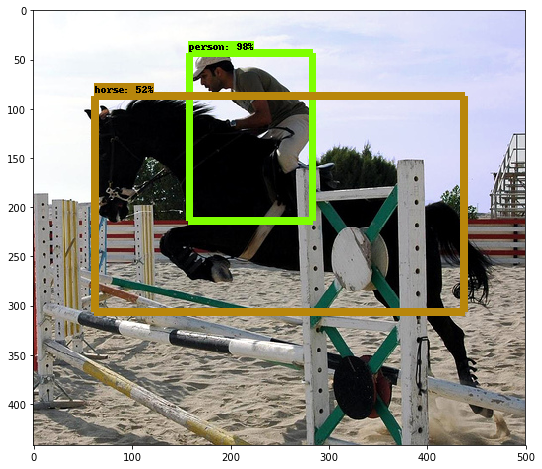

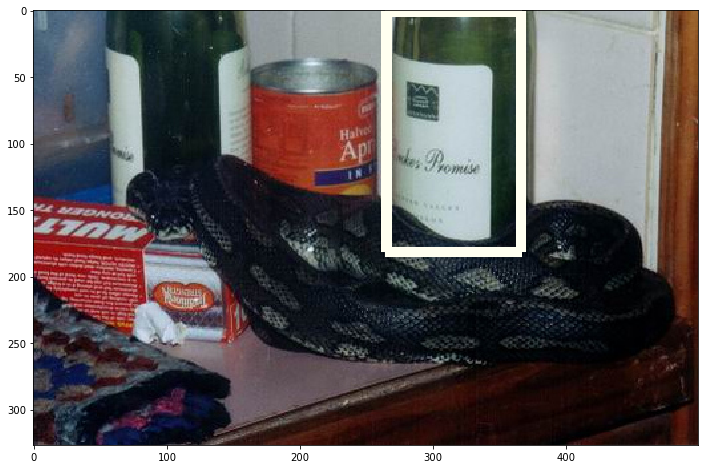

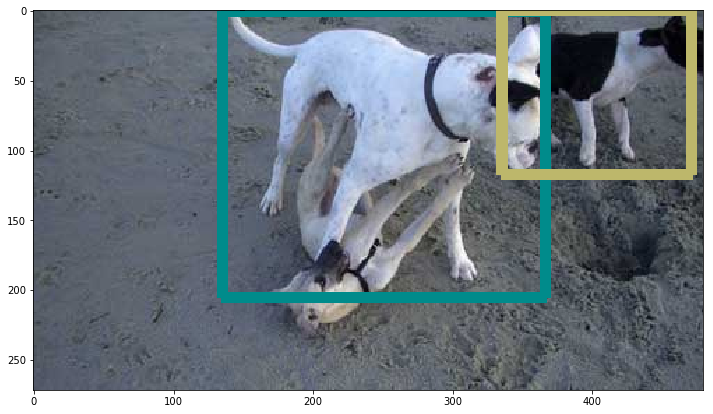

In [10]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        ind = 0
        for image_path in TEST_IMAGE_PATH:
            ind += 1
            if ind > 3:
                break
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

In [11]:
def get_box_el(box, el_list, w, h):
    l = []
    cur_dim = w
    for el_name in el_list:
        if el_name[0] == 'x':
            cur_dim = w
        else:
            cur_dim = h
        l.append(float(box.getElementsByTagName(el_name)[0].firstChild.data)/cur_dim)
    return l

def get_objects(filepath, im_shape):
    w = im_shape[1]
    h = im_shape[0]
    corners = ['ymin', 'xmin', 'ymax', 'xmax']
    xmldoc = minidom.parse(filepath)
    all_objects = []
    objects = xmldoc.getElementsByTagName('object')
    for obj in objects:
        nm = obj.getElementsByTagName('name')
        bndbox = obj.getElementsByTagName('bndbox')    
        all_objects.append((get_box_el(bndbox[0], corners, w, h), nm[0].firstChild.data))
        
    return all_objects

In [12]:
def get_area(s):    
    return (s[2] - s[0]) * (s[3] - s[1])

def intersection_area(a, b):
    dx = min(a[2], b[2]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[1], b[1])
    if (dx >= 0) and (dy >= 0):
        return dx * dy
    else:
        return 0

def IoU(box_1, box_2):
    return intersection_area(box_1, box_2) / (get_area(box_1) + get_area(box_2) - intersection_area(box_1, box_2))

def get_IoU(objects, boxes, scores, classes):
    l = []
    for obj in objects:
        if category_id.get(obj[1]) is None:
            continue
        cur_max = 0
        for i in range(len(boxes)):
            if scores[i] < 0.5:                
                break              
            if category_id.get(obj[1]) == classes[i]:# and IoU(boxes[i], obj[0]) > 0.5:
                cur_max = max(cur_max, IoU(boxes[i], obj[0]))                
        l.append(cur_max)
    return l

def get_mAP(objects, boxes, scores, classes):
    l = []
    for obj in objects:
        if category_id.get(obj[1]) is None:
            continue
        cur_max = 0
        for i in range(len(boxes)):
            if scores[i] < 0.5:                
                break                        
            if category_id.get(obj[1]) == classes[i] and IoU(boxes[i], obj[0]) > 0.5:
                cur_max = 1
                break
        l.append(cur_max)
    return l

def get_acc(objects, boxes, scores, classes):
    l = []
    for obj in objects:
        if category_id.get(obj[1]) is None:
            continue
        cur_max = 0
        for i in range(len(boxes)):
            if scores[i] < 0.5:                
                break                        
            if category_id.get(obj[1]) == classes[i]:
                cur_max = 1
                break
        l.append(cur_max)
    return l

In [13]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph,config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        all_IoU = []
        all_mAP = []
        all_acc = []
        for image_path in TEST_IMAGE_PATH:
            file_name = image_path[image_path.rfind('/')+1:image_path.rfind('.')] + '.xml'
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            objects = get_objects(ANNOTATIONS_PATH + file_name, image_np.shape)
            image_np_expanded = np.expand_dims(image_np, axis=0)
          
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})            
                        
            all_IoU += get_IoU(objects, boxes[0], scores[0], classes[0])
            all_mAP += get_mAP(objects, boxes[0], scores[0], classes[0])
            all_acc += get_acc(objects, boxes[0], scores[0], classes[0])
        
        print('Mean IoU:', np.mean(all_IoU))
        print('mAP:', '{:.1%}'.format(np.mean(all_mAP)))
        print('Accuracy:', '{:.1%}'.format(np.mean(all_acc)))

Mean IoU: 0.464725888225
mAP: 52.7%
Accuracy: 75.2%
